<a href="https://colab.research.google.com/github/liorKatzz/uber_prediction/blob/master/uber_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from google.colab import files
import seaborn as sns 
from datetime import datetime
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsRegressor
uploaded = files.upload()

Saving uber_nyc_enriched.zip to uber_nyc_enriched (2).zip


In [0]:
#Read the data
df = pd.read_csv('uber_nyc_enriched.zip')

In [0]:
# For now
df_orig = df.copy()
df = df.dropna()

# Exploring The Data


In [0]:
df_orig.head(5)

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
1,2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2,2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
4,2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y


As you will probably notice, the dataframe above contains all kinds of information about the pickups like date ,area, weather info, etc. 

In [0]:
print(df_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29101 entries, 0 to 29100
Data columns (total 13 columns):
pickup_dt    29101 non-null object
borough      26058 non-null object
pickups      29101 non-null int64
spd          29101 non-null float64
vsb          29101 non-null float64
temp         29101 non-null float64
dewp         29101 non-null float64
slp          29101 non-null float64
pcp01        29101 non-null float64
pcp06        29101 non-null float64
pcp24        29101 non-null float64
sd           29101 non-null float64
hday         29101 non-null object
dtypes: float64(9), int64(1), object(3)
memory usage: 2.9+ MB
None


As you can see, we have int type for pickups, the rest of the numric values are floats and ome are objects which are categorical attributes

Now, we will count all the null value in the dataset using this line of code:

In [0]:
print(df_orig.isnull().values.sum())

3043


Now, let's check the distribution of null values:

In [0]:
print(df_orig.isnull().sum())


pickup_dt       0
borough      3043
pickups         0
spd             0
vsb             0
temp            0
dewp            0
slp             0
pcp01           0
pcp06           0
pcp24           0
sd              0
hday            0
dtype: int64


We can easily see that the borough feature is the **problematic** one and we need to take care of it

For df we dropped the null values so let's check if it worked by counting its null values:

In [0]:
print(df.isnull().values.sum())

0


cool

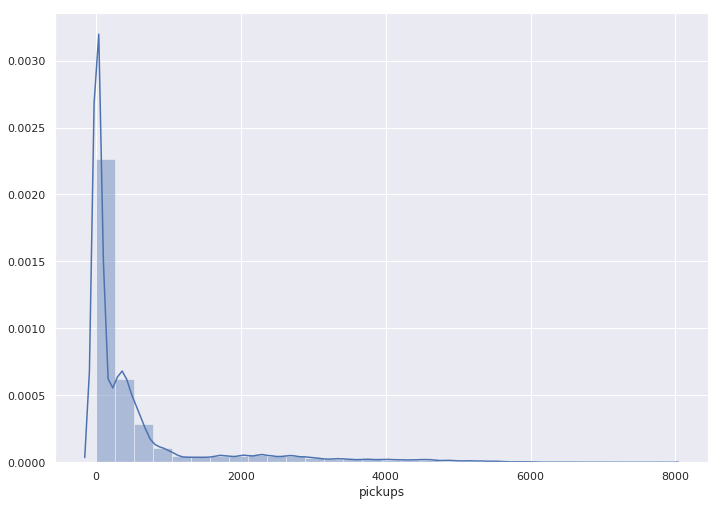

In [0]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['pickups'], bins=30)
plt.show()

Another potential **problem** is that the number of pickups are not "nicely" distributesd

N    27980
Y     1121
Name: hday, dtype: int64


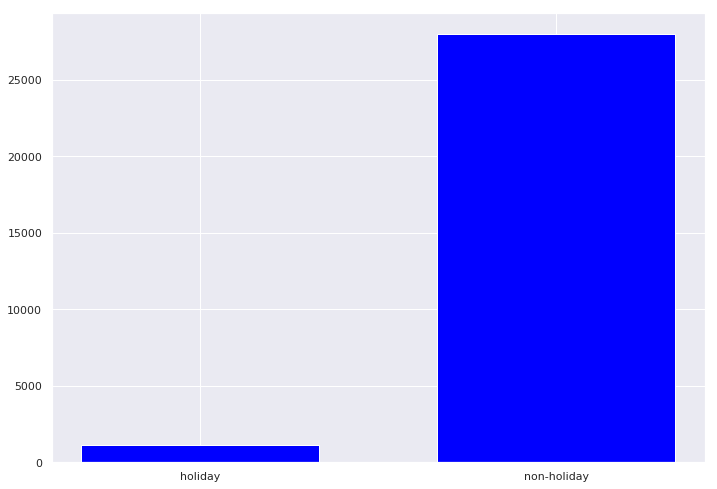

In [0]:
vals = list(df_orig['hday'].value_counts())
vals.reverse()
bar_test = plt.bar(['holiday', 'non-holiday'], vals, 1/1.5, color="blue")
print(df_orig['hday'].value_counts())

We can see a potential **problem** here, since we have a lot more non-holidays than holidays

In [0]:
df['pickups'].corr(df['temp'])


0.06369218205057028

In [0]:
df['pickups'].corr(df['hday'])

# Feature Engineering




In [0]:
# Encoding hday
df['hday'] = pd.Series(np.where(df.hday.values == 'Y', 1, 0),
          df.index)

In [0]:
# Change borough strings to categorial numbers
df['borough'] = pd.Categorical(df['borough'], categories=df['borough'].unique()).codes

In [0]:
def part_of_day(n):
  if 0 <= n < 6:
    return 0
  elif 6 <= n < 12:
    return 1
  elif 12 <= n < 18:
    return 2
  else:
    return 3

In [0]:
# Casting the date column t be datetime object and then extract hour and dow
df['pickup_dt'] = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['pickup_dt']]
df['hour'], df['dow'] = [d.hour for d in df['pickup_dt']], [d.weekday() for d in df['pickup_dt']]
df['pod'] = list(map(part_of_day, df['hour']))
df['dow'] = df['dow'].astype('category')


# Save the full date before droping it for the model
date = df['pickup_dt']
df = df.drop(['pickup_dt', 'hour'], axis=1)

In [0]:
df_onehot = pd.get_dummies(df, columns=['borough', 'hday', 'dow', 'pod'], prefix = ['borough', 'hday', 'dow', 'pod'])

In [0]:
df_onehot.head(3)

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,borough_0,borough_1,borough_2,borough_3,borough_4,borough_5,hday_0,hday_1,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,pod_0,pod_1,pod_2,pod_3
0,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
1,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
2,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [0]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26058 entries, 0 to 29099
Data columns (total 29 columns):
pickups      26058 non-null int64
spd          26058 non-null float64
vsb          26058 non-null float64
temp         26058 non-null float64
dewp         26058 non-null float64
slp          26058 non-null float64
pcp01        26058 non-null float64
pcp06        26058 non-null float64
pcp24        26058 non-null float64
sd           26058 non-null float64
borough_0    26058 non-null uint8
borough_1    26058 non-null uint8
borough_2    26058 non-null uint8
borough_3    26058 non-null uint8
borough_4    26058 non-null uint8
borough_5    26058 non-null uint8
hday_0       26058 non-null uint8
hday_1       26058 non-null uint8
dow_0        26058 non-null uint8
dow_1        26058 non-null uint8
dow_2        26058 non-null uint8
dow_3        26058 non-null uint8
dow_4        26058 non-null uint8
dow_5        26058 non-null uint8
dow_6        26058 non-null uint8
pod_0        26058 non-

In [0]:
print("Number of observations is: " + str(len(df)))

Number of observations is: 26058


# Splitting Data

In [0]:
from sklearn.model_selection import train_test_split
y = df_onehot['pickups']
X = df_onehot.drop(['pickups'], axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# TODO: number of pickups for each borough

# Modeling

##KNN

In [0]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [0]:
print(X[1:3])
print(y[1:3])
knn.predict(X_test[1:3])

   borough  spd   vsb  temp  dewp     slp  pcp01  pcp06  pcp24   sd  hday  \
1        1  5.0  10.0  30.0   7.0  1023.5    0.0    0.0    0.0  0.0     1   
2        2  5.0  10.0  30.0   7.0  1023.5    0.0    0.0    0.0  0.0     1   

   hour  dow  
1     1    3  
2     1    3  
1    1519
2       0
Name: pickups, dtype: int64


array([ 789.6, 1212.8])

In [0]:
knn.score(X_test, y_test)

0.17862847891477573

find best k, cross validation(?) feature engineering

## KNN with onehot

In [0]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=8, p=2,
          weights='uniform')

In [0]:
knn.score(X_test, y_test)

0.32224767068128557

##LightGBM

In [0]:
  from lightgbm import LGBMRegressor, plot_importance
  lgb = LGBMRegressor(n_estimators=10**4, max_depth=9, colsample_bytree=0.7, subsample=0.9, learning_rate=0.5)
  lgb.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), 
                  (X_test, y_test)], 
        verbose=100, early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
[100]	training's l2: 36887	valid_1's l2: 97161.2
Early stopping, best iteration is:
[107]	training's l2: 35515.9	valid_1's l2: 96451.2


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       importance_type='split', learning_rate=0.5, max_depth=9,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

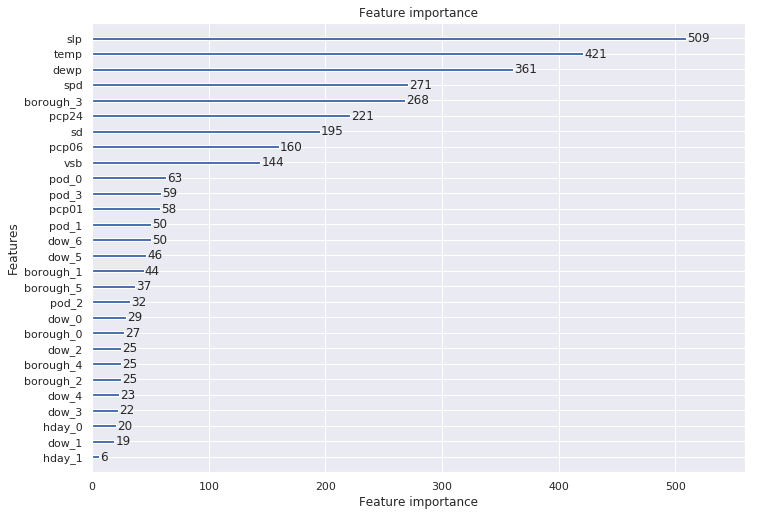

In [0]:
plot_importance(lgb)

Let's take down all the un-important features


In [0]:
features = ['borough', 'slp', 'hour', 'temp', 'dewp', 'dow', 'pcp24']

In [0]:
lgb = LGBMRegressor(n_estimators=10**4, max_depth=9, colsample_bytree=0.7, subsample=0.9, learning_rate=0.5)
lgb.fit(X_train[features], y_train, 
        eval_set=[(X_train[features], y_train), 
                  (X_test[features], y_test)], 
        verbose=100, early_stopping_rounds=10)

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's l2: 25046.7	valid_1's l2: 48555.9
[200]	valid_0's l2: 16427.3	valid_1's l2: 43755.6
Early stopping, best iteration is:
[233]	valid_0's l2: 14670.4	valid_1's l2: 42740.1


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       importance_type='split', learning_rate=0.5, max_depth=9,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

In [0]:
X_train['rides_pred'] = lgb.predict(X_train[features])
X_test['rides_pred'] = lgb.predict(X_test[features])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
pred_train =  (X_train['rides_pred'] - y_train).abs().mean()
print(pred_train)
pred_test = (X_test['rides_pred'] - y_test).abs().mean()
print(pred_test)

71.25192548818708
110.76681848327112


How to I check if this diff is good or not? figure it out

## KNN again

In [0]:
# Let's run KNN again with these features only
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X[features], y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [0]:
knn.score(X_test[features], y_test)

0.3223948921854053

In [0]:
# Took down dow
features2 = ['borough', 'slp', 'hour', 'temp', 'dewp', 'pcp24']

In [0]:
# Let's run KNN again with these features only
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X[features2], y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=4, p=2,
          weights='uniform')

In [0]:
knn.score(X_test[features2], y_test)

0.4058413225577824

##Regression with hotone

In [0]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [0]:
reg.predict(np.array([X_test.iloc[5555]]))

array([268.])

In [0]:
reg.score(X_test, y_test)

0.7118352616241843

Another **problem** that we're facing is that we can have negative values with regression, which is not possible